# FNC 8.2 — Exercises 1, 3, 4, 5 (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.2 — Power iteration**.

- Exercise **2** is a written problem and is answered in `习题解答/na_sol_datahub_8/main.tex`.
- Datasets are downloaded from `tobydriscoll.net` and cached under `./_fnc_assets`.

We implement **Function 8.2.3** (`poweriter`) and the modified symmetric version `powersym`.


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib h5py tqdm

import urllib.request
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import h5py
from scipy import sparse
from scipy.sparse.linalg import LinearOperator, eigsh
from tqdm import tqdm

DATA_DIR = Path('./_fnc_assets')
DATA_DIR.mkdir(exist_ok=True)
print('Asset dir:', DATA_DIR.resolve())


def download(url: str, dest: Path, desc: str = '') -> Path:
    '''Download `url` into `dest` if missing.'''
    dest = Path(dest)
    if dest.exists():
        return dest

    print('Downloading', desc or url)
    with urllib.request.urlopen(url) as r, open(dest, 'wb') as f:
        total = int(r.headers.get('Content-Length', 0) or 0)
        with tqdm(total=total, unit='B', unit_scale=True) as pbar:
            while True:
                chunk = r.read(1024 * 256)
                if not chunk:
                    break
                f.write(chunk)
                pbar.update(len(chunk))
    return dest


def load_jld2_sparse_csc(path: Path, var: str = 'A') -> sparse.csc_matrix:
    '''Load a Julia JLD2 SparseMatrixCSC stored as variable `var`.'''
    path = Path(path)
    with h5py.File(path, 'r') as h5:
        if var not in h5:
            raise KeyError(f"Variable {var!r} not found in {path}")
        ds = h5[var]
        rec = ds[()]
        m = int(rec['m'])
        n = int(rec['n'])

        colptr = np.array(h5[rec['colptr']], dtype=np.int64).ravel() - 1
        rowval = np.array(h5[rec['rowval']], dtype=np.int64).ravel() - 1
        nzval = np.array(h5[rec['nzval']]).ravel()

        return sparse.csc_matrix((nzval, rowval, colptr), shape=(m, n))


def density(S) -> float:
    m, n = S.shape
    return S.nnz / (m * n)


Asset dir: /Users/guanyu/Desktop/Google Drive/250321-Numerical analysis seminar/numerical-analysis-seminar-datahub/solution/code/ch8/_fnc_assets


## Power iteration (Function 8.2.3)

We follow the book’s implementation: at each iteration we normalize by the entry of `y = A x` having maximum absolute value.


In [2]:
def normalize_inf(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    s = np.max(np.abs(x))
    if s == 0:
        raise ValueError('cannot normalize the zero vector')
    return x / s


def poweriter(A, numiter: int, *, x0=None, rng=None):
    '''Function 8.2.3 (poweriter).'''
    n = A.shape[0]
    if x0 is None:
        rng = np.random.default_rng() if rng is None else rng
        x = rng.standard_normal(n)
    else:
        x = np.asarray(x0, dtype=float).reshape(n)

    x = normalize_inf(x)
    beta = np.empty(numiter, dtype=complex)

    for k in range(numiter):
        y = A @ x
        m = int(np.argmax(np.abs(y)))

        if x[m] == 0:
            raise ZeroDivisionError('x[m] is zero; cannot form beta')
        beta[k] = y[m] / x[m]

        if y[m] == 0:
            raise ZeroDivisionError('y[m] is zero; cannot rescale')
        x = y / y[m]

    if np.all(np.isreal(beta)):
        beta = beta.real
    return beta, x


def powersym(A, numiter: int, *, x0=None, rng=None):
    '''Power iteration with Rayleigh quotient eigenvalue estimates.'''
    n = A.shape[0]
    if x0 is None:
        rng = np.random.default_rng() if rng is None else rng
        x = rng.standard_normal(n)
    else:
        x = np.asarray(x0, dtype=float).reshape(n)

    x = normalize_inf(x)
    beta = np.empty(numiter, dtype=complex)

    for k in range(numiter):
        y = A @ x

        denom = np.vdot(x, x)
        if denom == 0:
            raise ZeroDivisionError('x^T x is zero')
        beta[k] = np.vdot(x, y) / denom

        m = int(np.argmax(np.abs(y)))
        if y[m] == 0:
            raise ZeroDivisionError('y[m] is zero; cannot rescale')
        x = y / y[m]

    if np.all(np.isreal(beta)):
        beta = beta.real
    return beta, x


## Exercise 1

Run 20 iterations and compare the observed error reduction to the prediction

\[ \frac{|\beta_{k+1}-\lambda_1|}{|\beta_k-\lambda_1|} \to \left|\frac{\lambda_2}{\lambda_1}\right|. \]


Exercise 1 summary

(a)
  lambda1 = 2.472841614740048
  lambda2 = 1.027158385259952
  predicted |lambda2/lambda1| = 0.41537572772040626
  observed median |err_{k+1}/err_k| = 0.4153757443445486
  beta_20 = 2.472841608554094

(b)
  lambda1 = 2.414213562373095
  lambda2 = -0.4142135623730951
  predicted |lambda2/lambda1| = 0.17157287525380993
  observed median |err_{k+1}/err_k| = 0.17157288520879568
  beta_20 = 2.414213562373093

(c)
  lambda1 = 12.480740698407857
  lambda2 = -0.4807406984078602
  predicted |lambda2/lambda1| = 0.03851860318427955
  observed median |err_{k+1}/err_k| = 0.0385185932240354
  beta_20 = 12.48074069840786

(d)
  lambda1 = (8.000000000000002+0j)
  lambda2 = (-5.999999999999999+0j)
  predicted |lambda2/lambda1| = 0.7499999999999998
  observed median |err_{k+1}/err_k| = 0.7486172985584268
  beta_20 = 8.043450124525213


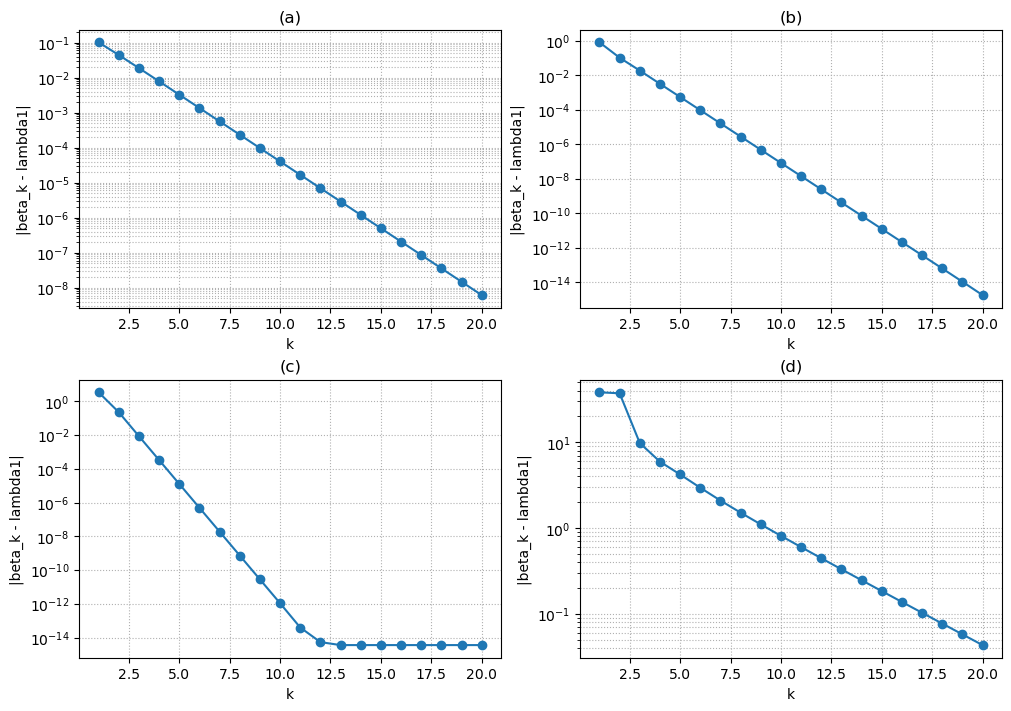

In [3]:
mats = {
    '(a)': np.array([[1.1, 1.0], [0.1, 2.4]]),
    '(b)': np.array([[2.0, 1.0], [1.0, 0.0]]),
    '(c)': np.array([[6.0, 5.0, 4.0], [5.0, 4.0, 3.0], [4.0, 3.0, 2.0]]),
    '(d)': np.array(
        [[8.0, -14.0, 0.0, -14.0],
         [-8.0, 1.0, 1.0, 1.0],
         [-4.0, -2.0, 0.0, 2.0],
         [8.0, -7.0, -1.0, -7.0]]
    ),
}

rng = np.random.default_rng(42)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)
axes = axes.ravel()

print('Exercise 1 summary')

for ax, (name, A) in zip(axes, mats.items()):
    eigvals = np.linalg.eigvals(A)
    order = np.argsort(-np.abs(eigvals))
    lam1 = eigvals[order[0]]
    lam2 = eigvals[order[1]]
    pred = abs(lam2 / lam1)

    beta, _ = poweriter(A, 20, rng=rng)
    err = beta - lam1

    ratios = np.abs(err[1:] / err[:-1])
    threshold = 1e-10 * abs(lam1)
    mask = (
        np.isfinite(ratios)
        & (np.abs(err[:-1]) > threshold)
        & (np.abs(err[1:]) > threshold)
    )
    r = ratios[mask]
    if r.size == 0:
        obs = float('nan')
    else:
        tail = r[-5:] if r.size >= 5 else r
        obs = float(np.median(tail))

    ax.semilogy(np.arange(1, 21), np.abs(err), marker='o')
    ax.set_title(name)
    ax.set_xlabel('k')
    ax.set_ylabel('|beta_k - lambda1|')
    ax.grid(True, which='both', ls=':')

    print()
    print(name)
    print('  lambda1 =', lam1)
    print('  lambda2 =', lam2)
    print('  predicted |lambda2/lambda1| =', pred)
    print('  observed median |err_{k+1}/err_k| =', obs)
    print('  beta_20 =', beta[-1])

plt.show()


## Exercise 3 — `poisson(n)` membrane matrix

We build the 2D five-point Laplacian (size `n^2 × n^2`), scaled by `(n+1)^2`, and:

- (a) `n=10`: spy plot, density, and the most common row nnz.
- (b) dominant eigenvalue for `n=10,15,20,25`.
- (c) run 100 steps of `poweriter` and plot `|beta_k - lambda1|` on a semilog scale.


A shape: (100, 100)
density(A): 0.046
most common row nnz: 5


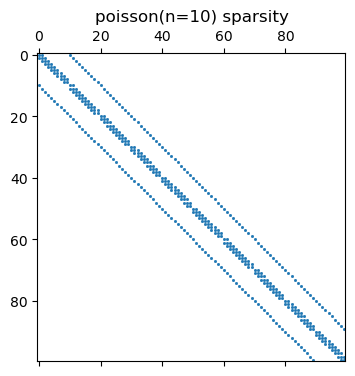

n=10: lambda1 ~ 948.394599229417
n=15: lambda1 ~ 2028.324127132909
n=20: lambda1 ~ 3508.297577461125
n=25: lambda1 ~ 5388.284795561140


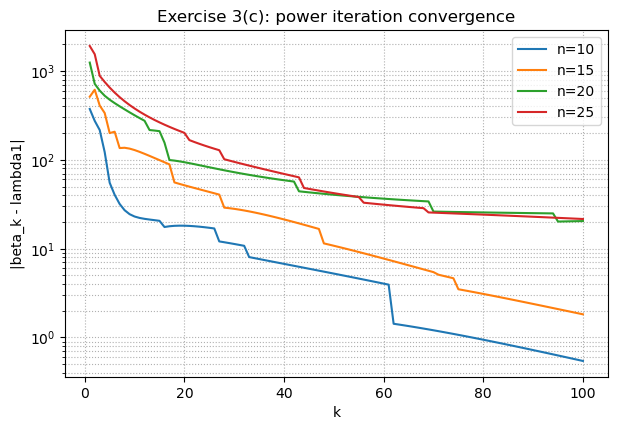

In [4]:
def poisson_2d(n: int) -> sparse.csc_matrix:
    T = sparse.diags(
        diagonals=[-np.ones(n - 1), 2 * np.ones(n), -np.ones(n - 1)],
        offsets=[-1, 0, 1],
        format='csc',
    )
    I = sparse.identity(n, format='csc')
    P = sparse.kron(I, T) + sparse.kron(T, I)
    return ((n + 1) ** 2) * P


# (a)
n = 10
A = poisson_2d(n)
print('A shape:', A.shape)
print('density(A):', density(A))

row_nnz = np.asarray(A.getnnz(axis=1)).ravel()
mode_nnz = int(np.bincount(row_nnz).argmax())
print('most common row nnz:', mode_nnz)

plt.figure(figsize=(4, 4))
plt.spy(A, markersize=1)
plt.title('poisson(n=10) sparsity')
plt.show()


# (b)
ns = [10, 15, 20, 25]
lam1_by_n = {}
for n in ns:
    A = poisson_2d(n).astype(float)
    lam1 = float(eigsh(A, k=1, which='LA', return_eigenvectors=False)[0])
    lam1_by_n[n] = lam1
    print(f'n={n:2d}: lambda1 ~ {lam1:.12f}')


# (c)
plt.figure(figsize=(7, 4.5))
rng = np.random.default_rng(2025)
for n in ns:
    A = poisson_2d(n).astype(float)
    beta, _ = poweriter(A, 100, rng=rng)
    lam1 = lam1_by_n[n]
    err = np.abs(beta - lam1)
    plt.semilogy(np.arange(1, 101), err, label=f'n={n}')

plt.xlabel('k')
plt.ylabel('|beta_k - lambda1|')
plt.title('Exercise 3(c): power iteration convergence')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()


## Exercise 4 — Leading eigenvalue of `A^T A`

We use the large, sparse actor–movie matrix `A` (from Exercise 8.1.5 / 8.1 Exercise 5) and run `poweriter` on the linear operator

\[ v \mapsto A^T (A v). \]


In [5]:
ACTORS_URL = 'https://tobydriscoll.net/fnc-julia/_static/resources/actors.jld2'
actors_path = download(ACTORS_URL, DATA_DIR / 'actors.jld2', desc='actors.jld2')

A = load_jld2_sparse_csc(actors_path).astype(float)
print('A shape (movies × actors):', A.shape, 'nnz:', A.nnz)

n = A.shape[1]

def ATA_matvec(v):
    return A.T @ (A @ v)

ATA = LinearOperator((n, n), matvec=ATA_matvec, dtype=float)

rng = np.random.default_rng(0)
beta, _ = poweriter(ATA, 60, rng=rng)

print('beta_60 =', beta[-1])
rel_change = np.abs(beta[-1] - beta[-2]) / np.abs(beta[-1])
print('relative change |beta_60-beta_59|/|beta_60| =', rel_change)

# verify against eigsh (same matvec, but ARPACK)
lam1_ref = float(eigsh(ATA, k=1, which='LA', return_eigenvectors=False, tol=1e-10)[0])
print('eigsh reference lambda1 =', lam1_ref)
print('absolute error |beta_60 - lambda1| =', abs(beta[-1] - lam1_ref))


A shape (movies × actors): (127823, 392400) nnz: 1470404


beta_60 = 1785.2190200809791
relative change |beta_60-beta_59|/|beta_60| = 1.727152896031308e-10


eigsh reference lambda1 = 1785.2190187812582
absolute error |beta_60 - lambda1| = 1.2997209068998927e-06


## Exercise 5 — Rayleigh quotient acceleration (`powersym`)

Compare `poweriter` vs `powersym` on the symmetric Fiedler matrix `F_{ij} = |i-j|` of size 100.


dominant eigenvalue lambda1 = 3473.6844212492924


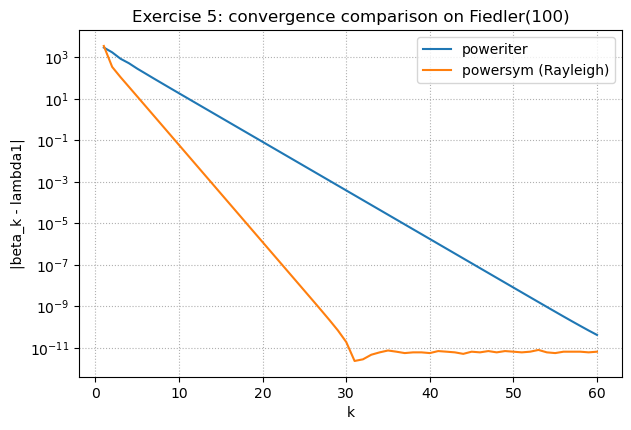

In [6]:
def fiedler(n: int) -> np.ndarray:
    x = np.arange(1, n + 1).reshape(-1, 1)
    return np.abs(x - x.T).astype(float)


F = fiedler(100)
lam1 = float(np.linalg.eigvalsh(F).max())
print('dominant eigenvalue lambda1 =', lam1)

rng = np.random.default_rng(123)
x0 = rng.standard_normal(F.shape[0])

beta_plain, _ = poweriter(F, 60, x0=x0)
beta_sym, _ = powersym(F, 60, x0=x0)

err_plain = np.abs(beta_plain - lam1)
err_sym = np.abs(beta_sym - lam1)

plt.figure(figsize=(7, 4.5))
plt.semilogy(np.arange(1, 61), err_plain, label='poweriter')
plt.semilogy(np.arange(1, 61), err_sym, label='powersym (Rayleigh)')
plt.xlabel('k')
plt.ylabel('|beta_k - lambda1|')
plt.title('Exercise 5: convergence comparison on Fiedler(100)')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()
